# BG-NBD ve Gamma-Gamma ile CLTV Prediction

### Veri Seti Hikayesi

Online Retail II isimli veri seti İngiltere merkezli online bir satış mağazasının 01/12/2009 - 09/12/2011 tarihleri arasındaki satışlarını içeriyor.
Kaynak:https://archive.ics.uci.edu/ml/datasets/Online+Retail+II

 Değişkenler
 InvoiceNo: Fatura numarası. Her işleme yani faturaya ait eşsiz numara. C ile başlıyorsa iptal edilen işlem.
 
 StockCode: Ürün kodu. Her bir ürün için eşsiz numara.
 
 Description: Ürün ismi
 
 Quantity: Ürün adedi. Faturalardaki ürünlerden kaçar tane satıldığını ifade etmektedir.
 
 InvoiceDate: Fatura tarihi ve zamanı.
 
 UnitPrice: Ürün fiyatı (Sterlin cinsinden)
 
 CustomerID: Eşsiz müşteri numarası
 
 Country: Ülke ismi. Müşterinin yaşadığı ülke.

----

In [1]:
#gerekli import işlemleri
# ! pip install lifetimes
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions


In [2]:
#tablo ayarları

pd.set_option("display.max.columns",None)
pd.set_option("display.width",500)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

from sklearn.preprocessing import MinMaxScaler #life time değerini düzenlemk için.


In [3]:
# aykırı değerleri baskılamak için kullanıcak fonksiyonlar:

#eşik belirlemek için fonksiyon
def outlier_thresholds(dataframe,variable):
    # 0.01 ve 0.99 yapmamazın sebebi çok fazla gözlemi değiştirmemek için.
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    QIR = quartile3 - quartile1
    up_limit = quartile3 + 1.5 *QIR
    low_limit = quartile1 - 1.5*QIR
    return low_limit,up_limit

#baskılamak için fonksiyon
def replace_with_thresholds(dataframe,variable):
    low_limit,up_limit = outlier_thresholds(dataframe,variable)
    # dataframe.loc [(dataframe[variable] < low_limit),variable] = low_limit
    dataframe.loc [(dataframe[variable] > up_limit),variable] = up_limit
  

## Verinin Hazırlanması

In [4]:
# datasetin import edilmesi

df_ =pd.read_excel(r"C:\Users\kkakt\Desktop\CRM\datasets\online_retail_II.xlsx",sheet_name="Year 2010-2011")
df= df_.copy()
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.5500,17850.0000,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.7500,17850.0000,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom


In [5]:
df.isnull().sum()

Invoice             0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
Price               0
Customer ID    135080
Country             0
dtype: int64

## Veri Ön İşleme

In [6]:
df.dropna(inplace=True)
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,406830.0000,12.0613,248.6931,-80995.0000,2.0000,5.0000,12.0000,80995.0000
Price,406830.0000,3.4605,69.3151,0.0000,1.2500,1.9500,3.7500,38970.0000
Customer ID,406830.0000,15287.6842,1713.6031,12346.0000,13953.0000,15152.0000,16791.0000,18287.0000


In [7]:
#iadeleri çıkarmak
df = df[~df["Invoice"].str.contains("C",na=False)]
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,397925.0000,13.0218,180.4200,1.0000,2.0000,6.0000,12.0000,80995.0000
Price,397925.0000,3.1162,22.0968,0.0000,1.2500,1.9500,3.7500,8142.7500
Customer ID,397925.0000,15294.3086,1713.1727,12346.0000,13969.0000,15159.0000,16795.0000,18287.0000


In [8]:
df = df[df["Quantity"]>0]
df = df[df["Price"]>0]

df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,397885.0000,12.9882,179.3316,1.0000,2.0000,6.0000,12.0000,80995.0000
Price,397885.0000,3.1165,22.0979,0.0010,1.2500,1.9500,3.7500,8142.7500
Customer ID,397885.0000,15294.4169,1713.1444,12346.0000,13969.0000,15159.0000,16795.0000,18287.0000


In [9]:
# aykırı değerleri baskılamak

replace_with_thresholds(df,"Quantity")
replace_with_thresholds(df,"Price")

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,397885.0000,11.8308,25.5231,1.0000,2.0000,6.0000,12.0000,298.5000
Price,397885.0000,2.8935,3.2272,0.0010,1.2500,1.9500,3.7500,37.0600
Customer ID,397885.0000,15294.4169,1713.1444,12346.0000,13969.0000,15159.0000,16795.0000,18287.0000


In [11]:
# total price değişkeni oluşturmak
df["Total_Price"] = df["Quantity"] * df["Price"]
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Total_Price
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0000,2010-12-01 08:26:00,2.5500,17850.0000,United Kingdom,15.3000
1,536365,71053,WHITE METAL LANTERN,6.0000,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom,20.3400
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0000,2010-12-01 08:26:00,2.7500,17850.0000,United Kingdom,22.0000
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0000,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom,20.3400
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0000,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom,20.3400


In [12]:
# analiz tarihini belirlemek
today_date = dt.datetime(2011,12,11)

## Lifetime Veri Yapısının Hazırlanması

#### recency: Son satın alma üzerinden geçen zaman. Haftalık. (kullanıcı özelinde)
#### T: Müşterinin yaşı. Haftalık. (analiz tarihinden ne kadar süre önce ilk satın alma yapılmış)
#### frequency: tekrar eden toplam satın alma sayısı (frequency>1)
#### monetary: satın alma başına ortalama kazanç

In [13]:
cltv_df = df.groupby("Customer ID").agg({
    "InvoiceDate" : [lambda x: (x.max() - x.min()).days, lambda x: (today_date - x.min()).days],
    "Invoice" : lambda x: x.nunique(),
    "Total_Price" : lambda x:x.sum()
})

In [14]:
# hiyerarşik adlandırmayı kaldırma

cltv_df.columns = cltv_df.columns.droplevel(0)
cltv_df.columns = ["recency","T","frequency","monetary"]

In [15]:
cltv_df["monetary"] = cltv_df["monetary"] / cltv_df["frequency"]
cltv_df.describe().T

,count,mean,std,min,25%,50%,75%,max
recency,4338.0000,130.4486,132.0396,0.0000,0.0000,92.5000,251.7500,373.0000
T,4338.0000,223.8310,117.8546,1.0000,113.0000,249.0000,327.0000,374.0000
frequency,4338.0000,4.2720,7.6980,1.0000,1.0000,2.0000,5.0000,209.0000
monetary,4338.0000,364.1185,367.2582,3.4500,176.8512,288.2255,422.0294,6207.6700


In [16]:
# birden fazla sipariş veren müşteriler tablosu için

cltv_df = cltv_df[(cltv_df["frequency"] > 1)]

In [17]:
# recency ve t değişkenlerini haftalık cinsine çevirme

cltv_df["recency"] = cltv_df["recency"] / 7
cltv_df["T"] = cltv_df["T"] / 7


In [18]:
cltv_df

,recency,T,frequency,monetary
Customer ID,,,,
12347.0000,52.1429,52.5714,7,615.7143
12348.0000,40.2857,51.2857,4,442.6950
12352.0000,37.1429,42.4286,8,219.5425
12356.0000,43.1429,46.5714,3,937.1433
12358.0000,21.2857,21.5714,2,575.2100
...,...,...,...,...
18272.0000,34.8571,35.2857,6,513.0967
18273.0000,36.4286,36.8571,3,68.0000
18282.0000,16.8571,18.1429,2,89.0250


## BG-NBD Modelinin Kurulması

In [19]:
bgf = BetaGeoFitter(penalizer_coef = 0.001)

#modülü fit ediyoruz.
bgf.fit(cltv_df["frequency"],
       cltv_df["recency"],
       cltv_df["T"])

<lifetimes.BetaGeoFitter: fitted with 2845 subjects, a: 0.12, alpha: 11.41, b: 2.49, r: 2.18>

### 1 hafta içinde en çok satın alma beklediğimiz 10 müşteri kimdir?

In [20]:
bgf.conditional_expected_number_of_purchases_up_to_time(1, # 1 hafta
                                                       cltv_df["frequency"],
                                                       cltv_df["recency"],
                                                       cltv_df["T"]).sort_values(ascending=False).head(10)

Customer ID
12748.0000   3.2495
14911.0000   3.1264
17841.0000   1.9402
13089.0000   1.5374
14606.0000   1.4639
15311.0000   1.4336
12971.0000   1.3569
14646.0000   1.2064
13408.0000   0.9862
18102.0000   0.9685
dtype: float64

In [21]:
#predict yöntemiyle 
cltv_df["expect_purch_1_week"]= bgf.predict(1, #hafta
           cltv_df["frequency"],
           cltv_df["recency"],
           cltv_df["T"])

cltv_df.head(10)

,recency,T,frequency,monetary,expect_purch_1_week
Customer ID,,,,,
12347.0000,52.1429,52.5714,7,615.7143,0.1413
12348.0000,40.2857,51.2857,4,442.6950,0.0920
12352.0000,37.1429,42.4286,8,219.5425,0.1824
12356.0000,43.1429,46.5714,3,937.1433,0.0862
12358.0000,21.2857,21.5714,2,575.2100,0.1223
12359.0000,39.1429,47.4286,4,1371.8500,0.0995
12360.0000,21.1429,28.7143,3,878.5333,0.1196
12362.0000,41.7143,42.2857,10,522.6230,0.2240
12363.0000,18.8571,34.7143,2,276.0000,0.0756


In [22]:
# 1 ayda beklenen satışlar için

cltv_df["expected_purch_1_month"]=bgf.predict(4,
            cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T'])

In [23]:
# 3 ayda toplam beklenen toplam satışlar için.

bgf.predict(4*3,
            cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T']).sum()

5271.112433826363

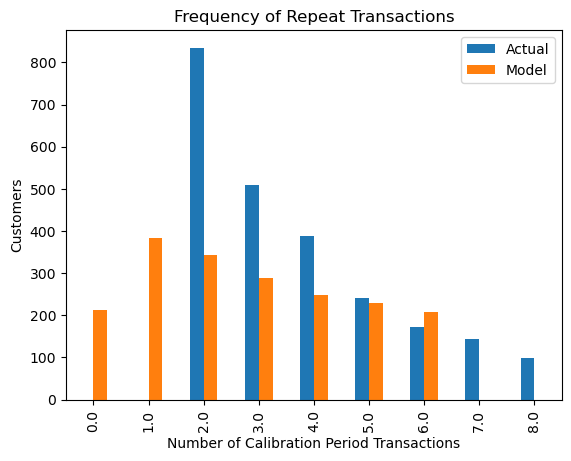

In [24]:
# grafiklerle tahmin sonuçlarının değerlendirilmesi
# tahmin sonuçlarının değerlendirilmesi 

plot_period_transactions(bgf)
plt.show()


## GAMMA-GAMMA Modelinin Kurulması

In [25]:
# expected avg profit'i modelliyoruz.

ggf  = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(cltv_df["frequency"],cltv_df["monetary"])

<lifetimes.GammaGammaFitter: fitted with 2845 subjects, p: 3.79, q: 0.34, v: 3.73>

In [26]:
ggf.conditional_expected_average_profit(cltv_df["frequency"],cltv_df["monetary"]).sort_values(ascending=False)

Customer ID
12415.0000   5772.1782
12590.0000   5029.4196
12435.0000   4288.9440
12409.0000   3918.8128
14088.0000   3917.1297
                ...   
17988.0000     29.5847
15516.0000     23.4070
18037.0000     12.6576
17816.0000     10.5291
16454.0000      5.8195
Length: 2845, dtype: float64

In [27]:
cltv_df["expected_average_profit"] = ggf.conditional_expected_average_profit(cltv_df["frequency"],cltv_df["monetary"])

In [30]:
cltv_df.sort_values("expected_average_profit",ascending=False).head(10)

,recency,T,frequency,monetary,expect_purch_1_week,expected_purch_1_month,expected_average_profit
Customer ID,,,,,,,
12415.0000,44.7143,48.2857,21,5724.3026,0.3796,1.5139,5772.1782
12590.0000,0.0000,30.2857,2,4591.1725,0.0115,0.0460,5029.4196
12435.0000,26.8571,38.2857,2,3914.9450,0.0763,0.3041,4288.9440
12409.0000,14.7143,26.1429,3,3690.8900,0.1174,0.4674,3918.8128
14088.0000,44.5714,46.1429,13,3864.5546,0.2603,1.0379,3917.1297
18102.0000,52.2857,52.5714,60,3859.7391,0.9685,3.8636,3870.9969
12753.0000,48.4286,51.8571,6,3571.5650,0.1261,0.5028,3678.5783
14646.0000,50.4286,50.7143,73,3646.0757,1.2064,4.8119,3654.8148
15749.0000,13.8571,47.5714,3,3028.7800,0.0280,0.1116,3216.0523


## BG-NBD ve GG modeli ile CLTV'nin hesaplanması.

In [66]:
cltv = ggf.customer_lifetime_value(bgf, #bg-nbd
                                  cltv_df["frequency"],
                                  cltv_df["recency"],
                                  cltv_df["T"],
                                  cltv_df["monetary"],
                                  time=3, #3 ay
                                  freq="W", #T'nin frekansı (haftalık)
                                  discount_rate=0.01)

In [67]:
cltv.head()

Customer ID
12347.0000   1128.4477
12348.0000    538.8089
12352.0000    517.5000
12356.0000   1083.0903
12358.0000    966.6727
Name: clv, dtype: float64

In [68]:
# index sorunu çözümü
cltv = cltv.reset_index()
cltv.head()

,Customer ID,clv
0,12347.0000,1128.4477
1,12348.0000,538.8089
2,12352.0000,517.5000
3,12356.0000,1083.0903
4,12358.0000,966.6727


In [69]:
# cltv_df ile birleştirme

cltv_final = cltv_df.merge(cltv,on="Customer ID",how="left")
cltv_final.sort_values(by="clv",ascending=False).head()

,Customer ID,recency,T,frequency,monetary,expect_purch_1_week,expected_purch_1_month,expected_average_profit,clv
1122,14646.0000,50.4286,50.7143,73,3646.0757,1.2064,4.8119,3654.8148,55741.0845
2761,18102.0000,52.2857,52.5714,60,3859.7391,0.9685,3.8636,3870.9969,47412.5801
843,14096.0000,13.8571,14.5714,17,3163.5882,0.7287,2.8955,3196.4361,29061.6614
36,12415.0000,44.7143,48.2857,21,5724.3026,0.3796,1.5139,5772.1782,27685.1000
1257,14911.0000,53.1429,53.4286,201,691.7101,3.1264,12.4722,692.3264,27377.4115


## CLTV'ye Göre Segmentlerin Oluşturulması

In [73]:
cltv_final["segment"] = pd.qcut(cltv_final["clv"],4,labels=["D","C","B","A"])
cltv_final

,Customer ID,recency,T,frequency,monetary,expect_purch_1_week,expected_purch_1_month,expected_average_profit,clv,segment
0,12347.0000,52.1429,52.5714,7,615.7143,0.1413,0.5635,631.9123,1128.4477,A
1,12348.0000,40.2857,51.2857,4,442.6950,0.0920,0.3668,463.7460,538.8089,B
2,12352.0000,37.1429,42.4286,8,219.5425,0.1824,0.7271,224.8868,517.5000,B
3,12356.0000,43.1429,46.5714,3,937.1433,0.0862,0.3435,995.9989,1083.0903,A
4,12358.0000,21.2857,21.5714,2,575.2100,0.1223,0.4862,631.9022,966.6727,A
...,...,...,...,...,...,...,...,...,...,...
2840,18272.0000,34.8571,35.2857,6,513.0967,0.1721,0.6856,529.0185,1146.2057,A
2841,18273.0000,36.4286,36.8571,3,68.0000,0.1043,0.4157,73.4942,96.5648,D
2842,18282.0000,16.8571,18.1429,2,89.0250,0.1357,0.5392,99.5249,168.5946,D
2843,18283.0000,47.5714,48.2857,16,130.9300,0.3017,1.2034,132.6012,505.5117,C


In [77]:
# segmentlere göre analiz işlemi
cltv_final.groupby("segment").agg({"count","mean","sum"})

Customer ID                     recency                        T               frequency                  monetary                expect_purch_1_week              expected_purch_1_month              expected_average_profit                         clv                
                  sum       mean count        sum    mean count        sum    mean count       sum    mean count         sum     mean count                 sum   mean count                    sum   mean count                     sum     mean count          sum      mean count
segment                                                                                                                                                                                                                                                                             
D       11077635.0000 15558.4761   712 15716.5714 22.0738   712 28811.0000 40.4649   712      2182  3.0646   712 130981.7123 183.9631   712             50.5898 0.0711   712               201.4774 0.2830   712             141999.6650 199.4377   712  102027.4901  143.2970   712
C       10885150.0000 15309.6343   711 21806.1429 30.6697   711 27097.0000 38.1111   711      2912  4.0956   711 193174.9847 271.6948   711             85.7309 0.1206   711               341.3936 0.4802   711             206179.7461 289.9856   711  270743.0065  380.7919   711
B       10915854.0000 15352.8186   711 20985.0000 29.5148   711 24751.1429 34.8117   711      3869  5.4416   711 265517.6312 373.4425   711            115.5066 0.1625   711               459.6926 0.6465   711             280058.9431 393.8944   711  489356.3925  688.2650   711
A       10627572.0000 14947.3586   711 22333.1429 31.4109   711 24518.1429 34.4840   711      8076 11.3586   711 469159.4581 659.8586   711            194.4993 0.2736   711               774.3298 1.0891   711             487674.7239 685.8998   711 1580097.9284 2222.3600   711

## Çalışmanın Fonksiyonlaştırılması

In [105]:
from lifetimes import BetaGeoFitter 
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions

def create_cltv_p(dataframe,month=3,csv=False):
    #veri ön işleme
    dataframe = dataframe[~(dataframe["Invoice"].str.contains("C",na=False))]
    dataframe = dataframe[dataframe["Quantity"]>0]
    dataframe = dataframe[dataframe["Price"]>0]
    #aykırı temizleme
    replace_with_thresholds(dataframe,"Quantity")
    replace_with_thresholds(dataframe,"Price")
    #total_price değişkeni
    dataframe["total_price"] = dataframe["Price"] * dataframe["Quantity"]
    #today_date
    today_date = dt.datetime(2011,12,11)
    
    #metrik hesaplamk için değişkenleri oluşturmak
    cltv_df = dataframe.groupby("Customer ID").agg({
        "InvoiceDate" : [lambda x:(x.max() - x.min()).days ,lambda x:(today_date - x.min()).days],
        "Invoice" : lambda x:x.nunique(),
        "total_price" : lambda x:x.sum()})
    cltv_df.columns = cltv_df.columns.droplevel(0)
    cltv_df.columns = ["recency","T","frequency","monetary"]
    
    cltv_df["recency"] = cltv_df["recency"] / 7
    cltv_df["T"] = cltv_df["T"] / 7
    cltv_df = cltv_df[cltv_df["frequency"] > 1]
    cltv_df["monetary"] = cltv_df["frequency"] / cltv_df["monetary"]  
    
    #bg-nbd modeli oluşturma
    bgf = BetaGeoFitter(penalizer_coef=0.001)
    bgf.fit(cltv_df["frequency"],
           cltv_df["recency"],
           cltv_df["T"],
           )
    # 3 aylık tahmin işlemi 
    cltv_df["expect_purch_3_month"] = bgf.predict(4*month,cltv_df["frequency"],
           cltv_df["recency"],
           cltv_df["T"],
           )
    
    #gamma gamma modeli
    ggf = GammaGammaFitter(penalizer_coef =0.001)
    ggf.fit(cltv_df["frequency"],
           (cltv_df["monetary"]))
    cltv_df["expected_average_profit"] = ggf.conditional_expected_average_profit(cltv_df["frequency"],cltv_df["monetary"])
    
    #customer liftetime value
    clvt = ggf.customer_lifetime_value(bgf,
                                      cltv_df["frequency"],
                                      cltv_df["recency"],
                                      cltv_df["T"],
                                      cltv_df["monetary"],
                                      time = month, #ay
                                      freq = "W",
                                      discount_rate=0.01)
    
    #cltv değerini eklemek cltv_df eklemek
    ctlv_final = cltv_df.merge(cltv,on="Customer ID",how = "left")
    
    #segmentlere ayırmak
    cltv_final["segment"] = pd.qcut(cltv_final["clv"],4,labels = ["D","C","B","A"])
    
    if csv:
        cltv_final.to_csv("cltv_analiys.csv")
    return cltv_final

In [106]:
df = df_.copy()

In [107]:
create_cltv_p(df)

,Customer ID,recency,T,frequency,monetary,expect_purch_1_week,expected_purch_1_month,expected_average_profit,clv,segment
0,12347.0000,52.1429,52.5714,7,615.7143,0.1413,0.5635,631.9123,1128.4477,A
1,12348.0000,40.2857,51.2857,4,442.6950,0.0920,0.3668,463.7460,538.8089,B
2,12352.0000,37.1429,42.4286,8,219.5425,0.1824,0.7271,224.8868,517.5000,B
3,12356.0000,43.1429,46.5714,3,937.1433,0.0862,0.3435,995.9989,1083.0903,A
4,12358.0000,21.2857,21.5714,2,575.2100,0.1223,0.4862,631.9022,966.6727,A
...,...,...,...,...,...,...,...,...,...,...
2840,18272.0000,34.8571,35.2857,6,513.0967,0.1721,0.6856,529.0185,1146.2057,A
2841,18273.0000,36.4286,36.8571,3,68.0000,0.1043,0.4157,73.4942,96.5648,D
2842,18282.0000,16.8571,18.1429,2,89.0250,0.1357,0.5392,99.5249,168.5946,D
2843,18283.0000,47.5714,48.2857,16,130.9300,0.3017,1.2034,132.6012,505.5117,C
